# Implementation of Finite Mixture Model

<details>
  <summary>Table of Contents</summary>
  <ol>
    <li>
      Import Needed Filepaths and Libraries
    </li>
    <li>
    Load Dataset Into Pandas DataFrame
    </li>
    <li>
    Define Response Variable `y`
    </li>
    <li>
    Set Up Reproducible Random Number Generator
    </li>
    <li>
      Setting Up Mixture Model
      <ul>
        <li>Initial Parameters</li>
        <li>Setting Priors</li>
      </ul>
    </li>
    <li>Gibbs Sampler Implementation
      <ul>
        <li>Gibbs Sampler Updates</li>
      </ul>
</li>
  </ol>
</details>

## Import Needed Filepaths and Libraries

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
from texas_gerrymandering_hb4.config import FINAL_CSV


## Load Dataset Into Pandas DataFrame
Our processed dataset is read into a Pandas DataFrame.

In [122]:
df = pd.read_csv(FINAL_CSV)


## Obtain a PCA-Weighted Average of Compactness Scores
Compactness metrics are a widely-accepted indicator of gerrymandering. The PCA-weighted average of compactness metrics in our dataset, labeled as 'compactness_index' in our Pandas DataFrame, will be the outcome for the mixture. Compactness index values near 1 are considered "compact/not gerrymandered" while values near 0 are labeled "non-compact/gerrymandered".

### Define Which Columns in Dataset Contain Compactness Metrics

In [123]:
compactness_cols = [
    "polsby_popper",
    "reock",
    "convex_hull_ratio",
    "schwartzberg",
]

### Obtain Matrix of Compactness Metrics from DataFrame

In [124]:
X = df[compactness_cols].values

### Standardizing Compactness Metrics to Mean 0 and Variance 1

In [125]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Obtain First Principal Component Scores

In [126]:
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_std).flatten()

### Clarify that High Compactness Indicates Greater Compactness/Less Gerrymandering

In [127]:
if np.corrcoef(pc1, df["polsby_popper"].values)[0, 1] < 0:
    pc1 = -pc1

### Rescale Principal Component 1 to [0,1]

In [128]:
pc1_min, pc1_max = pc1.min(), pc1.max()
compactness_index = (pc1 - pc1_min) / (pc1_max - pc1_min)

### Store Compactness Index in DataFrame

In [129]:
df["compactness_index"] = compactness_index

### Defining Response Variable `y`

In [130]:
y = df["compactness_index"].values

### Defining Sample Size
* `n` denotes the sample size, which is the number of Congressional districts in Texas (38).

In [131]:
n = len(y)

## Scaled Inverse-$\chi^2$ Sampler
* This is the conjugate prior for the variance in the normal model.
* This will be used to update $\sigma_1^2$ and $\sigma_2^2$ in the Gibbs sampler.

In [132]:
def rinvchisq(df, scale):
    return df * scale / np.random.chisquare(df)


### Set Up Reproducible Random Number Generator

In [133]:
np.random.seed(123)

### Initial Parameters
* These parameters represent starting guesses for the Gibbs sampler.

#### Initialize $\lambda$
`lambda` ($\lambda$) is the mixing proportion. Starting from a place of ignorance, we assume a perfect mix between the two, and that our means are the sample means and our variances are the sample variances. $\lambda$ is set to 0.5 to serve as a neutral initial guess.

In [134]:
_lambda = 0.5

#### Initialize Means: $\mu_1$ and $\mu_2$
* `mu_1` and `mu_2` represent the initial means for each component.
* Initial parameters based on the data help circumvent warmup challenges.

In [135]:
mu_1 = np.mean(y)
mu_2 = np.mean(y)

#### Initialize Variances: $\sigma^2_1$ and $\sigma^2_2$
* `sigma_squared_1` and `sigma_squared_2` are the initial variances for each component.
* The initial component variances are the sample variance of the compactness index.
* "Bayesian Data Analysis" (Third Edition) encourages inital parameters based on data.

In [136]:
sigma_squared_1 = np.var(y,ddof=1)
sigma_squared_2 = np.var(y, ddof=1)

#### Setting Priors for $\lambda$: $\alpha_1$ and $\alpha_2$
* `alpha_1` and `alpha_2` are the priors for lambda.
$$\lambda \sim Beta(\alpha_2, \alpha_2)$$
Because the prior for lambda is Beta(2,2), `alpha_1` and `alpha_2` are both set to 2.
* This is a conjugate prior. Also, as a reminder, Beta(2,2) is also a Dirchilet distribution. What is beneficial about this is that the probability of obtaining 0 or 1, which is a degenerate model, is 0. Hence, as you get closer to 0 or 1, the likelihood is tiny. As a result, the problem is pushed further away from a degenerate value, so they become less likely to accidently become a point of convergence.

In [137]:
alpha_1 = 2.0
alpha_2 = 2.0

#### Setting Priors for Means: $\mu_1$ and $\mu_2$
* The means `m0_1` and `mu0_2` are coming from the same distribution.
* Keep in mind that compactness index is between 0 and 1.

In [138]:
mu0_1 = 0.5
mu0_2 = 0.5

#### Setting Priors for Variances: $\sigma_1^2$ and $\sigma_2^2$

In [139]:
sigma_0_squared_1 = 0.20**2
sigma_0_squared_2 = 0.20**2

#### Setting Priors for Degrees of Freedom

In [140]:
degrees_of_freedom0_1 = 2
degrees_of_freedom0_2 = 2

### Gibbs Sampler Parameters

In [141]:
iterations = 1000
warmup = 500

### Storage for Samples

In [142]:
lambda_samples = np.zeros(iterations)
mu1_samples = np.zeros(iterations)
mu2_samples = np.zeros(iterations)
sigma_squared_1_samples = np.zeros(iterations)
sigma_squared_2_samples = np.zeros(iterations)
z_samples = np.zeros((iterations, n), dtype=int)

## Gibbs Sampler Implementation
* The process for the Gibbs sampler involves initializing parameters, iterative sampling, and continuing the iterations until convergence.
* The benefits of the Gibbs sampler are that it handles complex, high-dimensional distributions and is easier to implement than direct sampling methods.

In [143]:
for i in range(iterations):
    # ---- Update z (component membership for each district) ----
    lik_1 = _lambda * norm.pdf(y, loc=mu_1, scale=np.sqrt(sigma_squared_1))
    lik_2 = (1 - _lambda) * norm.pdf(y, loc=mu_2, scale=np.sqrt(sigma_squared_2))
    z_probs = lik_1 / (lik_1 + lik_2)
    z = np.random.binomial(1, z_probs)  # 1 = component 1, 0 = component 2

    # ---- Update lambda ----
    alpha_lambda_post = alpha_1 + np.sum(z)
    beta_lambda_post = alpha_2 + (n - np.sum(z))
    _lambda = np.random.beta(alpha_lambda_post, beta_lambda_post)

    # ---- Update mu_1 ----
    n1 = np.sum(z)
    if n1 > 0:
        y1_mean = np.mean(y[z == 1])
        # *** FIXED: use sigma_squared_1 in BOTH places ***
        mu1_post_mean = ((mu0_1 / sigma_0_squared_1) + n1 * y1_mean / sigma_squared_1) / \
                        (1 / sigma_0_squared_1 + n1 / sigma_squared_1)
        mu1_post_sd = np.sqrt(1 / (1 / sigma_0_squared_1 + n1 / sigma_squared_1))
    else:
        mu1_post_mean = mu0_1
        mu1_post_sd = np.sqrt(sigma_0_squared_1)
    mu_1 = np.random.normal(mu1_post_mean, mu1_post_sd)
 # ---- Update mu_2 ----
    n2 = n - n1
    if n2 > 0:
        y2_mean = np.mean(y[z == 0])
        mu2_post_mean = ((mu0_2 / sigma_0_squared_2) + n2 * y2_mean / sigma_squared_2) / \
                        (1 / sigma_0_squared_2 + n2 / sigma_squared_2)
        mu2_post_sd = np.sqrt(1 / (1 / sigma_0_squared_2 + n2 / sigma_squared_2))
    else:
        mu2_post_mean = mu0_2
        mu2_post_sd = np.sqrt(sigma_0_squared_2)
    mu_2 = np.random.normal(mu2_post_mean, mu2_post_sd)

    # ---- Update sigma_1_sq (scaled inverse-chi-squared) ----
    nu1_post = degrees_of_freedom0_1 + n1
    if n1 > 0:
        ss1 = np.sum((y[z == 1] - mu_1) ** 2)
    else:
        ss1 = 0.0
    sigma1_post_scale = (degrees_of_freedom0_1 * sigma_0_squared_1 + ss1) / nu1_post
    sigma_1_sq = rinvchisq(nu1_post, sigma1_post_scale)

    # ---- Update sigma_2_sq (scaled inverse-chi-squared) ----
    nu2_post = degrees_of_freedom0_2 + n2
    if n2 > 0:
        ss2 = np.sum((y[z == 0] - mu_2) ** 2)
    else:
        ss2 = 0.0
    sigma2_post_scale = (degrees_of_freedom0_2 * sigma_0_squared_2 + ss2) / nu2_post
    sigma_2_sq = rinvchisq(nu2_post, sigma2_post_scale)
# ---- IMPORTANT: feed σ² back into the state ----
    sigma_squared_1 = sigma_1_sq
    sigma_squared_2 = sigma_2_sq

    # ---- Store samples ----
    lambda_samples[i] = _lambda
    mu1_samples[i] = mu_1
    mu2_samples[i] = mu_2
    sigma_squared_1_samples[i] = sigma_1_sq
    sigma_squared_2_samples[i] = sigma_2_sq
    z_samples[i, :] = z


### Discard Warmup Draws

In [144]:
lambda_post = lambda_samples[warmup:]
mu1_post = mu1_samples[warmup:]
mu2_post = mu2_samples[warmup:]
sigma1_post = sigma_squared_1_samples[warmup:]
sigma2_post = sigma_squared_2_samples[warmup:]
z_post = z_samples[warmup:, :]

### Print Posterior Means

In [145]:
print("Posterior mean lambda:", lambda_post.mean())
print("Posterior mean mu_1 (compactness):", mu1_post.mean())
print("Posterior mean mu_2 (compactness):", mu2_post.mean())
print("Posterior mean sigma1^2:", sigma1_post.mean())
print("Posterior mean sigma2^2:", sigma2_post.mean())


Posterior mean lambda: 0.5205737773296438
Posterior mean mu_1 (compactness): 0.4210668770077086
Posterior mean mu_2 (compactness): 0.3959291441571395
Posterior mean sigma1^2: 0.05252060567131386
Posterior mean sigma2^2: 0.05514660893834961


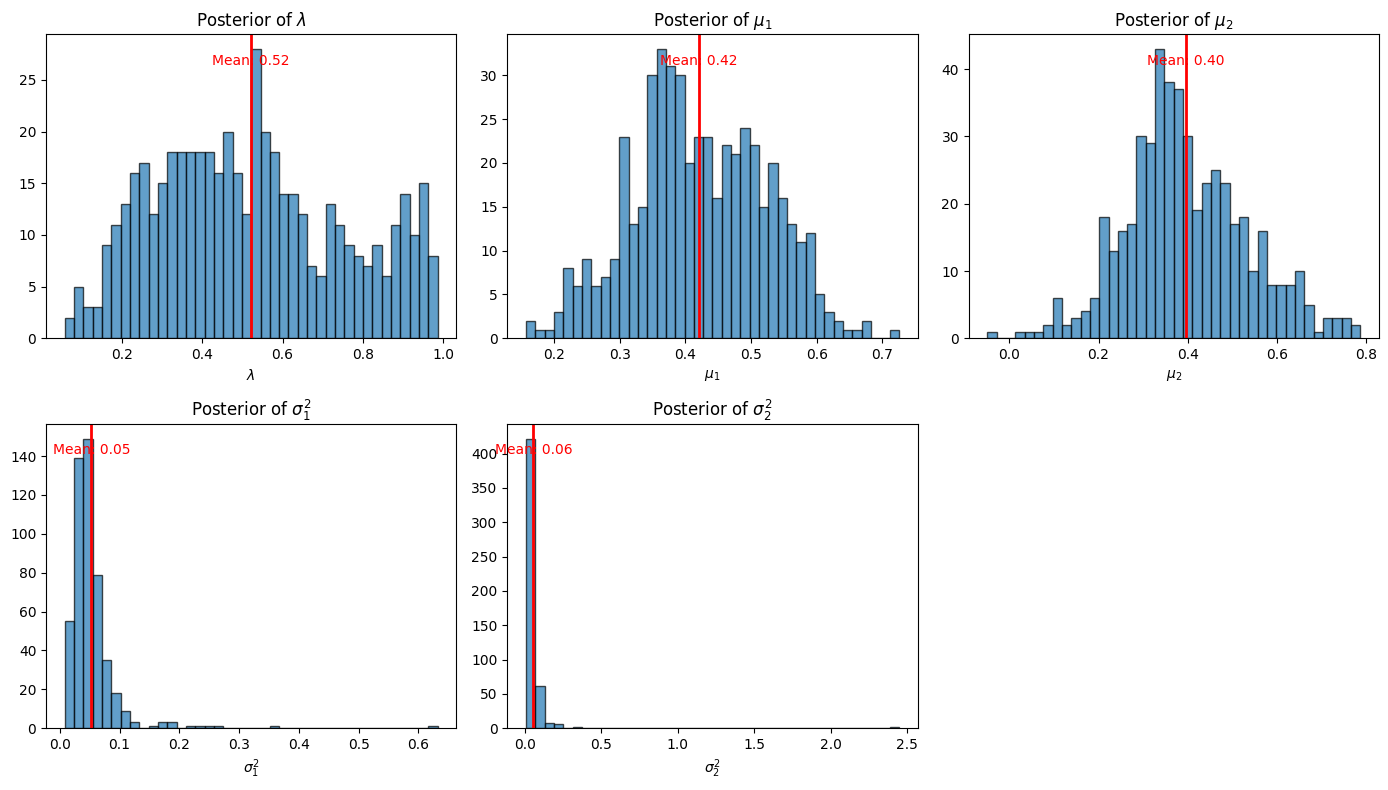

In [146]:
posteriors = [
    (r"$\lambda$",   lambda_post),
    (r"$\mu_1$",     mu1_post),
    (r"$\mu_2$",     mu2_post),
    (r"$\sigma_1^2$", sigma1_post),
    (r"$\sigma_2^2$", sigma2_post),
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for ax, (name, samples) in zip(axes, posteriors):
    # histogram
    ax.hist(samples, bins=40, edgecolor="black", alpha=0.7)

    # posterior mean
    m = samples.mean()
    ax.axvline(m, color="red", linewidth=2)

    # label for the mean
    ymax = ax.get_ylim()[1]
    ax.text(m, ymax * 0.9, f"Mean: {m:.2f}", color="red", ha="center")

    ax.set_title(f"Posterior of {name}")
    ax.set_xlabel(name)

# remove the unused 6th subplot
for j in range(len(posteriors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Posterior Probability of Gerrymandering

### Determining Which Component is Gerrymandered for Each Iteration

In [147]:
# For each iteration, decide which component is "low-compactness" (gerrymandered-ish)
is_low1 = mu1_post < mu2_post                   # True if comp 1 has lower mean compactness
gerr_label_per_iter = np.where(is_low1, 1, 0)   # 1 if comp 1 is low-compactness, else 0

In [148]:
# Posterior P(geometrically gerrymandered) for each district:
# proportion of iterations where its z equals that iteration's gerrymandered label
post_prob_geom_gerr = np.mean(
    z_post == gerr_label_per_iter[:, None],
    axis=0
)

In [149]:
# Store in dataframe
df["post_prob_geom_gerrymandered"] = post_prob_geom_gerr

# For backward compatibility with your previous code name:
df["post_prob_gerrymandered"] = df["post_prob_geom_gerrymandered"]

df[["district_id", "compactness_index", "post_prob_gerrymandered"]].head()


,district_id,compactness_index,post_prob_gerrymandered
0,1,0.403531,0.598
1,2,0.305874,0.652
2,3,0.417277,0.564
3,4,0.061802,0.798
4,5,0.393908,0.544


## Ranking Districts By Posterior Probability

### Sort Districts from Most Likely to Least Likely to Be Gerrymandered

In [150]:
df_sorted = df.sort_values("post_prob_gerrymandered", ascending=False)

### Choose Columns to Include

In [151]:
cols_to_show = [
    "district_id",
    "compactness_index",
    "post_prob_gerrymandered",
]

In [152]:
# Optional columns – only include if they’re actually present
for c in ["pct_minority", "dem_share"]:
    if c in df_sorted.columns:
        cols_to_show.append(c)

### Show 20 Districts with the Highest Probability of Being Gerrymandered

In [153]:
df_sorted[cols_to_show].head(20)

,district_id,compactness_index,post_prob_gerrymandered,dem_share
14,15,0.078903,0.806,0.445939
6,7,0.000000,0.800,0.632036
3,4,0.061802,0.798,0.405732
13,14,0.040070,0.790,0.389740
32,33,0.028250,0.780,0.688378
35,36,0.134082,0.754,0.387174
26,27,0.174912,0.748,0.415234
9,10,0.165394,0.738,0.393264
7,8,0.165469,0.734,0.388563
31,32,0.222402,0.728,0.457105
